In [1]:
import uproot
import awkward as ak
import numpy as np
import math
import hist
import matplotlib.pyplot as plt
import os
import subprocess
import vector
from scipy.optimize import curve_fit
from scipy.integrate import quad

In [2]:
vector.register_awkward() 

In [3]:
DATATYPE="data"
assert((DATATYPE=="mc") or (DATATYPE=="data"))
BASEDIR="../Runs" # basedir where to look for runXXX.DATATYPE.root files
IS_MC=True if DATATYPE=="mc" else False

In [4]:
def getTracks(events):
    return ak.zip({"px":events["Muon_Px"],
                       "py":events["Muon_Py"],
                       "pz":events["Muon_Pz"],
                       "E":events["Muon_E"],
                       "charge":events["Muon_Charge"],
                       "thetaAbs":events["Muon_thetaAbs"],
                       "matched":events["Muon_matchedTrgThreshold"]},
                    with_name='Momentum4D')

In [5]:
def scan(dataDescription, 
              hInvMass:hist.Hist, hQualInvMass:hist.Hist,
              eventSelector=lambda x:[True]*len(x),
              trackSelector=lambda x:[True]*len(x),
              verbose:bool=False):
    """ Loop over data to fill the invariant mass histogram.
        
        :param: dataDescription: is anything uproot.iterate can take.
                typical something like run*.data.root:eventsTree in our case
        :param: eventSelector: returns an array of bool from an array of events
        :param: trackSelector: returns an array of bool from an array of tracks
    """

    for batch in uproot.iterate(dataDescription,
                                ["isCINT","isCMUL","isCMSL","Muon_Px","Muon_Py","Muon_Pz","Muon_E","Muon_Charge","Muon_thetaAbs","Muon_matchedTrgThreshold"],                                
                                 step_size="100 MB", report=True):
        events=batch[0] # batch[1] is the report info
        if len(events) < 1000:
            print("something is wrong",batch[0:5]) # this is a protection for some corrupted input data files 
            break
            
        goodEvents = events[eventSelector(events)] #selection des évènements CMUL
        tracks = getTracks(events) #on utilise la fonction getTracks définie précédemment
        goodTracks=tracks[trackSelector(tracks)] #selection des évènements (eta, theta et trigger)
        
        #pairs = ak.combinations(goodTracks, 2)
        #one, two = ak.unzip(pairs)
        #rapidity_cut = (abs(one.eta<4)) & (abs(one.eta>2))
        #opposite_charge_cut = (one.charge + two.charge == 0) & (abs(one.eta<2))
        #quality_one = one[opposite_charge_cut]
        #quality_two = two[opposite_charge_cut]
        #invariant_mass = (quality_one + quality_two).mass
        
        pairs = ak.combinations(goodTracks, 2) #toutes les combinaisons de 2 traces
        one, two = ak.unzip(pairs)
        quality_one, quality_two = ak.unzip(pairs[(one.charge + two.charge == 0) & (abs(one.eta) <4) & (abs(one.eta)>2.5) 
                                                 & (abs(two.eta)<4) & (abs(two.eta)>2.5)]) #selection pairs signes opposées et y dans l'acceptance
        invariant_mass = (one + two).mass #masse invariante sans distinction des good pairs
        quality_invariant_mass = (quality_one + quality_two).mass #masse invariante avec correction
    
        hInvMass.fill(ak.flatten(invariant_mass))
        hQualInvMass.fill(ak.flatten(quality_invariant_mass))


        if verbose:
            print(batch[1])

In [6]:
%%time
#Pas de sélection sur les events et tracks
vhInvMass = hist.Hist(hist.axis.Regular(bins=200,start=1.5,stop=5,name='invariant mass without selection'))
vhQualInvMass = hist.Hist(hist.axis.Regular(bins=200,start=1.5,stop=5,name='invariant mass with good pairs'))
#Selection sur les events et tracks
vhInvMassEvSel = hist.Hist(hist.axis.Regular(bins=200,start=1.5,stop=5,name='invariant mass with good pairs'))
vhQualInvMassEvSel = hist.Hist(hist.axis.Regular(bins=200,start=1.5,stop=5,name='invariant mass with good pairs and good tracks'))


scan(dataDescription=f"{BASEDIR}/run*.{DATATYPE}.root:eventsTree",
          hInvMass=vhInvMass, hQualInvMass=vhQualInvMass)

scan(dataDescription=f"{BASEDIR}/run*.{DATATYPE}.root:eventsTree",
          hInvMass=vhInvMassEvSel, hQualInvMass=vhQualInvMassEvSel,
          eventSelector=lambda x: x["isCMUL"]==True,
          trackSelector=lambda x: (x.eta<-2.5) & (x.eta>-4) & (x["thetaAbs"]>2) & (x["thetaAbs"]<9) & (x["matched"]==2))

CPU times: user 2min 49s, sys: 5.2 s, total: 2min 55s
Wall time: 3min 16s


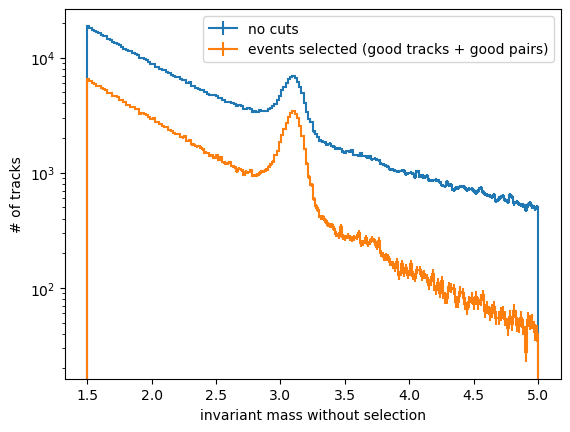

CPU times: user 1.29 s, sys: 159 ms, total: 1.45 s
Wall time: 1.45 s


In [7]:
%%time
vhInvMass.plot(label="no cuts") #Aucune selection
vhQualInvMassEvSel.plot(label="events selected (good tracks + good pairs)")
#plt.plot(x_data,y_data_model) #Modèle avec les valeurs adéquates pour le fit CB2 MC et le fit background sur une portion des valeurs exp
plt.yscale("log")
plt.ylabel("# of tracks")
plt.legend()
plt.show()

In [8]:
#CrystalBall2 prend en argument une liste de valeurs de x
def CrystalBall2(x, mu, sigma, alpha, alphabis, n, nbis, N):
    A = ((n/np.abs(alpha))**n)*np.exp(-(np.abs(alpha)**2)/2.)
    B = (n/np.abs(alpha))-np.abs(alpha)
    C = ((nbis/np.abs(alphabis))**n)*np.exp(-(np.abs(alphabis)**2)/2.)
    D = (nbis/np.abs(alphabis))-np.abs(alphabis)
    y = np.array([], dtype=float)
    for i in x:
        if(((i-mu)/sigma > alpha) and ((i-mu)/sigma < alphabis)):
            y = np.append(y, np.exp(-((i-mu)**2)/(2*sigma**2)))
        elif ((i-mu)/sigma < alpha):
            y = np.append(y, A*((B- (i -mu)/(sigma))**(-n)))
        elif((i-mu)/sigma > alphabis):
            y = np.append(y, C*((D+ (i -mu)/(sigma))**(-nbis)))
        else:
            y = np.append(y, 0.)
    return y*N

#CrystalBall2_2 prend en argument une valeur de x
def CrystalBall2_2(i, mu, sigma, alpha, alphabis, n, nbis, N):
    A = ((n/np.abs(alpha))**n)*np.exp(-(np.abs(alpha)**2)/2.)
    B = (n/np.abs(alpha))-np.abs(alpha)
    C = ((nbis/np.abs(alphabis))**n)*np.exp(-(np.abs(alphabis)**2)/2.)
    D = (nbis/np.abs(alphabis))-np.abs(alphabis)
    y = np.array([], dtype=float)
    if(((i-mu)/sigma > alpha) and ((i-mu)/sigma < alphabis)):
        y = np.exp(-((i-mu)**2)/(2*sigma**2))
    elif ((i-mu)/sigma < alpha):
        y = A*((B- (i -mu)/(sigma))**(-n))
    elif((i-mu)/sigma > alphabis):
        y = C*((D+ (i -mu)/(sigma))**(-nbis))
    return y*N

In [9]:
def NoiseVWG(x, mu, alpha, beta, N):
    y = np.array([], dtype=float)
    for i in x:
        sigma = alpha + beta*((i-mu)/mu)
        y = np.append(y, N * np.exp(-((i-mu)**2)/(2*sigma**2)))
    return y

In [19]:
def CB2withNoise(x, mu_CB2, sigma, N_CB2, mu_DE, alpha_DE, beta ,N_DE): #x est une liste
    alpha, alphabis, n, nbis=-7.16686241e-01,2.28952917e+00,4.41736692e+00,2.61183775e+00
    #sigma = 6.10076777e-02
    return CrystalBall2(x, mu_CB2, sigma, alpha, alphabis, n, nbis, N_CB2) + NoiseVWG(x, mu_DE, alpha_DE, beta, N_DE)

In [11]:
#Création des listes de valeurs 
x_data=[]
y_data=[]
      
for i in range(15000,50000,175):
    x_data.append(i/10000)

for i in vhQualInvMassEvSel:
      y_data.append(i)

In [35]:
#Fit de la fonction CB2+background avec les listes x_data et y_data pour obtenir mu, N_CB2 et les arguments de noise
%time
popt_CB2wNoise, pcov_CB2wNoise = curve_fit(CB2withNoise, x_data, y_data, p0=[3.1, 1 , 1 , 6.29517373e-07 , 4.91666545e-01 , 1.19404276e-07 , 1],
                    bounds=([3., 0.04 , 0. , 0. , 0 , 0 , 0.],[3.2 , 1, np.inf , 1 , 1 , 1 , np.inf]))

print(popt_CB2wNoise,pcov_CB2wNoise)
mu_fitCB2wNoise,sigma_fit,N_fitCB2wNoise, mu_DE_fitCB2wNoise, alpha_DE_fitCB2wNoise, beta_fitCB2wNoise, N_DE_fitCB2wNoise= popt_CB2wNoise
var_mu, var_sigma, var_N=pcov_CB2wNoise[0,0], pcov_CB2wNoise[1,1], pcov_CB2wNoise[2,2]
print('Variance de la masse du JPsi (mu CB2) :',var_mu)
print('Variance du sigma (mu CB2) :',var_sigma)
print('Variance de l amplitude CB2 :',var_N)
y_data_fitCB2wNoise=CB2withNoise(x_data,mu_fitCB2wNoise,sigma_fit,N_fitCB2wNoise, mu_DE_fitCB2wNoise, alpha_DE_fitCB2wNoise, beta_fitCB2wNoise, N_DE_fitCB2wNoise)

y_CB2_fit = CrystalBall2(x_data,mu_fitCB2wNoise, sigma_fit, -7.16686241e-01,2.28952917e+00,4.41736692e+00,2.61183775e+00,N_fitCB2wNoise)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.54 µs
[3.09315872e+00 6.28625742e-02 2.92484828e+03 2.28048586e-01
 5.81482466e-01 3.58232722e-02 2.41849565e+04] [[ 4.51257975e-07 -1.53151483e-07  2.38867303e-03 -2.77787032e-05
   3.73814631e-06 -4.56483806e-06  8.30732651e-01]
 [-1.53151483e-07  5.74857133e-07 -9.51110370e-03  5.08109702e-05
  -5.54859196e-06  8.25281337e-06 -1.58315545e+00]
 [ 2.38867303e-03 -9.51110370e-03  5.78360516e+02  8.55234663e-02
   1.62601936e-02  1.21092613e-02 -4.00128539e+03]
 [-2.77787032e-05  5.08109702e-05  8.55234663e-02  1.13408276e-01
  -1.59322032e-02  1.87267306e-02 -3.38281223e+03]
 [ 3.73814631e-06 -5.54859196e-06  1.62601936e-02 -1.59322032e-02
   2.34705155e-03 -2.63759484e-03  4.68931219e+02]
 [-4.56483806e-06  8.25281337e-06  1.21092613e-02  1.87267306e-02
  -2.63759484e-03  3.09272321e-03 -5.58215275e+02]
 [ 8.30732651e-01 -1.58315545e+00 -4.00128539e+03 -3.38281223e+03
   4.68931219e+02 -5.58215275e+02  1.01282266e+08]]
Variance

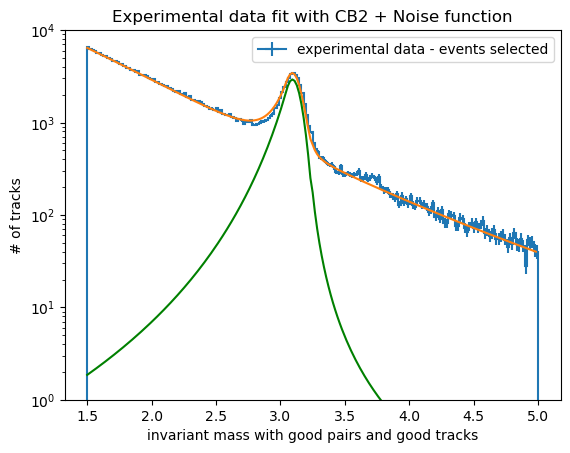

CPU times: user 694 ms, sys: 128 ms, total: 822 ms
Wall time: 620 ms


In [31]:
%%time
vhQualInvMassEvSel.plot(label="experimental data - events selected")
plt.plot(x_data,y_data_fitCB2wNoise)
plt.plot(x_data,y_CB2_fit,'g')
plt.yscale("log")
plt.ylabel("# of tracks")
plt.legend()
plt.title('Experimental data fit with CB2 + Noise function')
plt.ylim(1,10000)
plt.show()

In [32]:
y_data_finale=[]
for i in x_data:
    y_data_finale.append(CrystalBall2_2(i, mu_fitCB2wNoise, 6.10076777e-02,-7.16686241e-01,2.28952917e+00,4.41736692e+00,2.61183775e+00,N_fitCB2wNoise))

I = quad(CrystalBall2_2,1,5,
        args=(mu_fitCB2wNoise, 6.10076777e-02,-7.16686241e-01,2.28952917e+00,4.41736692e+00,2.61183775e+00,N_fitCB2wNoise))
I = I / vhQualInvMassEvSel.axes[0].widths[0]
print('Valeur de l intégrale en utilisant la fonction quad de scipy',I)


Valeur de l intégrale en utilisant la fonction quad de scipy [3.40882795e+04 4.56267185e-04]


In [33]:
#import sympy as sp

# définir les variables
#mu,sigma,alpha,alpha1,n,n1,N = ('mu sigma alpha alpha1 n n1 N') 

# définir le point où l'on veut calculer la dérivée partielle
#point=(mu_fitCB2wNoise, 6.10076777e-02,-7.16686241e-01,2.28952917e+00,4.41736692e+00,2.61183775e+00,N_fitCB2wNoise)

# calculer la dérivée partielle par rapport à x
#dx = sp.diff(CrystalBall2_2, mu)

# calculer la dérivée partielle par rapport à y
#dy = sp.diff(CrystalBall2_2, sigma)

# calculer la dérivée partielle par rapport à z
#dz = sp.diff(CrystalBall2_2, alpha)

# afficher les résultats
#print("df/dx =", dx.subs(x, point[0]).subs(y, point[1]).subs(z, point[2]))
#print("df/dy =", dy.subs(x, point[0]).subs(y, point[1]).subs(z, point[2]))
#print("df/dz =", dz.subs(x, point[0]).subs(y, point[1]).subs(z, point[2]))


In [41]:
var_alpha,var_alpha1,var_n,var_n1 = 3.82025732e-04,1.74935625e-02,2.11990082e-01,1.42526094e-01

# définir le point où l'on veut calculer la dérivée partielle
point = [mu_fitCB2wNoise, sigma_fit,-7.16686241e-01,2.28952917e+00,4.41736692e+00,2.61183775e+00,N_fitCB2wNoise]

# définir la précision pour les calculs numériques
eps = 1e-10

# calculer la dérivée partielle par rapport à mu
d_mu = (CrystalBall2(x_data,point[0] + eps, point[1], point[2], point[3], point[4], point[5], point[6]) - CrystalBall2(x_data,point[0], point[1], point[2], point[3], point[4], point[5], point[6])) / eps
d_mu = var_mu * d_mu

# calculer la dérivée partielle par rapport à sigma
d_sigma = (CrystalBall2(x_data,point[0], point[1] + eps, point[2], point[3], point[4], point[5], point[6]) - CrystalBall2(x_data,point[0], point[1], point[2], point[3], point[4], point[5], point[6])) / eps
d_sigma = var_sigma*d_sigma

# calculer la dérivée partielle par rapport à alpha
d_alpha = (CrystalBall2(x_data,point[0], point[1], point[2] + eps, point[3], point[4], point[5], point[6]) - CrystalBall2(x_data,point[0], point[1], point[2], point[3], point[4], point[5], point[6])) / eps
d_alpha = np.abs(var_alpha*d_alpha)
d_alpha1 = (CrystalBall2(x_data,point[0], point[1], point[2], point[3]+eps, point[4], point[5], point[6]) - CrystalBall2(x_data,point[0], point[1], point[2], point[3], point[4], point[5], point[6])) / eps
d_alpha1 = np.abs(var_alpha1*d_alpha1)
d_n = (CrystalBall2(x_data,point[0], point[1], point[2], point[3], point[4]+eps, point[5], point[6]) - CrystalBall2(x_data,point[0], point[1], point[2], point[3], point[4], point[5], point[6])) / eps
d_n = np.abs(var_n*d_n)
d_n1 = (CrystalBall2(x_data,point[0], point[1], point[2], point[3], point[4], point[5]+eps, point[6]) - CrystalBall2(x_data,point[0], point[1], point[2], point[3], point[4], point[5], point[6])) / eps
d_n1 = np.abs(var_n1*d_n1)
d_N = (CrystalBall2(x_data,point[0], point[1], point[2], point[3], point[4], point[5], point[6]+eps) - CrystalBall2(x_data,point[0], point[1], point[2], point[3], point[4], point[5], point[6])) / eps
d_N = np.abs(var_N*d_N)

# liste des listes des dérivées
#d_list=[d_mu, d_sigma, d_alpha, d_alpha1, d_n, d_n1]
d_list_stat=[d_mu, d_sigma]


pas=x_data[1]-x_data[0]
integrale_list = []
for i in range(0,len(d_list)):
    a=0
    for j in d_list[i]:
        a = a + j*pas
    integrale_list.append(a/vhQualInvMassEvSel.axes[0].widths[0])
print(integrale_list)

uncertainty_stat_NJPsi = sum(integrale_list)
print("Incertitude statistique sur le nombre de J/Psi :", uncertainty_stat_NJPsi)

[0.0015061029449069893, 0.32275634679450027]
Incertitude statistique sur le nombre de J/Psi : 0.32426244973940727
